In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
db = sqlite3.connect("iceform.db")
cur = db.cursor()

In [4]:
cur.execute("SELECT short_ngram_id, id FROM unique_ngrams")
data = cur.fetchall()

cur.executemany("UPDATE ngram_coords SET short_ngram_id = ? WHERE unique_ngram_id = ?", data)
db.commit()

In [5]:
# df_text = pd.read_sql_query("""
# SELECT nc.text_id, nc.sentence_id, nc.start, nc.end, nc.unique_ngram_id, nc.short_ngram_id, group_concat(ni.representation, " ") as text
# FROM ngram_coords nc
#     JOIN ngram_content con ON nc.unique_ngram_id = con.ngram_id
#     JOIN ngram_item ni ON con.ngram_item_id = ni.id
#     JOIN (
#         SELECT nc.id, count(nc.id) as true_n, (end - start) + 1 as full_n
#         FROM ngram_coords nc
#             JOIN ngram_content con ON nc.unique_ngram_id = con.ngram_id
#         GROUP BY nc.id
#         HAVING true_n = full_n
#     ) as nogaps ON nogaps.id = nc.id
# GROUP BY nc.text_id, nc.sentence_id, nc.start, nc.end, nc.unique_ngram_id, nc.short_ngram_id
# ORDER BY nc.text_id, nc.sentence_id, nc.start, con.id
# """, con=db)

In [6]:
# df_text.head()

,text_id,sentence_id,start,end,unique_ngram_id,short_ngram_id,text
0,0,2,4,7,129,8,PrpNom V_heita NNom_móðir PProGen
1,0,2,4,6,1896,88,V_heita NNom_móðir PProGen
2,0,2,5,7,191,77,PrpNom V_heita PProGen
3,0,4,0,3,32,8,PrpNom V_heita PProGen NNom_kona
4,0,4,1,3,478,88,V_heita PProGen NNom_kona


In [5]:
df = pd.read_sql_query("""
SELECT nc.unique_ngram_id, nc.text_id, nc.sentence_id, sl.sent_length, 
        (1.0 * nc.start / sl.sent_length) as position, nc.start, nc.end, 
        nclu.short_ngram_id, nclu.cluster, t.topic, t.prob
FROM ngram_coords nc
    JOIN (
        SELECT nc.id, count(nc.id) as true_n, (end - start) + 1 as full_n
        FROM ngram_coords nc
            JOIN ngram_content con ON nc.unique_ngram_id = con.ngram_id
        GROUP BY nc.id
        HAVING true_n = full_n
    ) as nogaps ON nogaps.id = nc.id
    JOIN (
    SELECT text_id, sentence_id, max(idx) + 1 as sent_length
        FROM text_content
    GROUP BY text_id, sentence_id
    ) as sl ON nc.text_id = sl.text_id AND nc.sentence_id = sl.sentence_id
    JOIN topics t ON nc.text_id = t.text_id AND nc.sentence_id = t.sentence_id
    JOIN new_clusters nclu ON nc.unique_ngram_id = nclu.unique_ngram_id AND nc.short_ngram_id = nclu.short_ngram_id
""", con=db)

In [6]:
df.shape

(1260360, 11)

In [7]:
df.head()

,unique_ngram_id,text_id,sentence_id,sent_length,position,start,end,short_ngram_id,cluster,topic,prob
0,1,25,142,32,0.34375,11,13,1,1,0,0.013907
1,1,25,142,32,0.34375,11,13,1,1,1,0.013915
2,1,25,142,32,0.34375,11,13,1,1,2,0.013910
3,1,25,142,32,0.34375,11,13,1,1,3,0.013914
4,1,25,142,32,0.34375,11,13,1,1,4,0.013923


In [8]:
df = df.pivot_table(
    index=["unique_ngram_id", "text_id", "sentence_id", "sent_length", "position", 
           "start", "end", "short_ngram_id", "cluster"],
    columns="topic", values="prob"
).fillna(0).reset_index()

In [9]:
df.head()

topic,unique_ngram_id,text_id,sentence_id,sent_length,position,start,end,short_ngram_id,cluster,0,1,2,3,4,5,6,7
0,1,0,343,17,0.647059,11,13,1,1,0.020852,0.020876,0.020870,0.020873,0.020877,0.853906,0.020876,0.020869
1,1,0,415,16,0.187500,3,5,1,1,0.062531,0.062539,0.062535,0.062552,0.562102,0.062658,0.062545,0.062538
2,1,1,485,14,0.642857,9,11,1,1,0.041703,0.041759,0.707736,0.041742,0.041752,0.041760,0.041786,0.041762
3,1,2,358,15,0.066667,1,3,1,1,0.011380,0.011391,0.011392,0.011394,0.011394,0.011391,0.011399,0.920258
4,1,2,659,20,0.050000,1,3,1,1,0.012520,0.012520,0.012519,0.012526,0.012523,0.012521,0.012519,0.912351


In [10]:
df["array"] = df[list(range(0, 8))].apply(np.array, axis=1)

In [11]:
df = df.drop(list(range(0, 8)), axis=1)
df.head()

topic,unique_ngram_id,text_id,sentence_id,sent_length,position,start,end,short_ngram_id,cluster,array
0,1,0,343,17,0.647059,11,13,1,1,"[0.02085243910551071, 0.020876357331871986, 0...."
1,1,0,415,16,0.187500,3,5,1,1,"[0.06253091245889664, 0.0625385046005249, 0.06..."
2,1,1,485,14,0.642857,9,11,1,1,"[0.041703421622514725, 0.04175862297415733, 0...."
3,1,2,358,15,0.066667,1,3,1,1,"[0.011380157433450222, 0.011391021311283112, 0..."
4,1,2,659,20,0.050000,1,3,1,1,"[0.01252011675387621, 0.012520460411906242, 0...."


In [12]:
total = df #df.merge(df_text)
total.head()

topic,unique_ngram_id,text_id,sentence_id,sent_length,position,start,end,short_ngram_id,cluster,array
0,1,0,343,17,0.647059,11,13,1,1,"[0.02085243910551071, 0.020876357331871986, 0...."
1,1,0,415,16,0.187500,3,5,1,1,"[0.06253091245889664, 0.0625385046005249, 0.06..."
2,1,1,485,14,0.642857,9,11,1,1,"[0.041703421622514725, 0.04175862297415733, 0...."
3,1,2,358,15,0.066667,1,3,1,1,"[0.011380157433450222, 0.011391021311283112, 0..."
4,1,2,659,20,0.050000,1,3,1,1,"[0.01252011675387621, 0.012520460411906242, 0...."


In [13]:
euclidean_distances([df["array"][0]], [df["array"][2]])

array([[1.06488621]])

In [14]:
import pickle

with open("total_df_arrays.pkl", "wb") as f:
    pickle.dump(total, f)

In [97]:
from scipy.stats import median_abs_deviation

def get_cosine(x):
    X = cosine_similarity(np.stack(x))
    np.fill_diagonal(X, np.nan)
    return X

def mean_cosine(x):
    return np.nanmean(get_cosine(x))

def err_cosine(x):
    if len(x) == 1:
        return None
    return np.nanstd(get_cosine(x))

def count_unique(x):
    return len(x.unique())

def median_dev_cosine(x):
    return median_abs_deviation(get_cosine(x), axis=None, nan_policy="omit")

def median_cosine(x):
    return np.nanmedian(get_cosine(x))

In [16]:
total["text_sent"] = total["text_id"].apply(str) + ":" + total["sentence_id"].apply(str)

In [17]:
total.head()

topic,unique_ngram_id,text_id,sentence_id,sent_length,position,start,end,short_ngram_id,cluster,array,text_sent
0,1,0,343,17,0.647059,11,13,1,1,"[0.02085243910551071, 0.020876357331871986, 0....",0:343
1,1,0,415,16,0.187500,3,5,1,1,"[0.06253091245889664, 0.0625385046005249, 0.06...",0:415
2,1,1,485,14,0.642857,9,11,1,1,"[0.041703421622514725, 0.04175862297415733, 0....",1:485
3,1,2,358,15,0.066667,1,3,1,1,"[0.011380157433450222, 0.011391021311283112, 0...",2:358
4,1,2,659,20,0.050000,1,3,1,1,"[0.01252011675387621, 0.012520460411906242, 0....",2:659


In [24]:
total["end_rev"] = total["end"] * -1

In [25]:
total = total.sort_values(
    by=["text_id", "sentence_id", "start", "end_rev"]).drop_duplicates(
    subset=["unique_ngram_id", "text_id", "sentence_id"], keep="first")

In [26]:
total.shape

(211853, 12)

In [27]:
from scipy.stats import zscore

In [28]:
array = total[(total["short_ngram_id"] == 119) & (total["cluster"] == 12)]["array"].values

In [29]:
array = np.array(array.tolist(), np.float32)

In [34]:
# zscore([2] * 10)

In [30]:
X = get_cosine(array)
mean_arr = np.nanmean(X, axis=0)
print(mean_arr)

new_arr = array[np.where(mean_arr > 0.5)]
print(new_arr)

X = get_cosine(new_arr)
print(np.nanmean(X, axis=0))

[0.57512134 0.58078706 0.57512134 0.58078474 0.58078474 0.29082754
 0.30115086 0.30116144]
[[0.         0.         0.         0.         0.         0.
  0.96628726 0.        ]
 [0.01138084 0.01139375 0.01139012 0.01138841 0.01138046 0.0113866
  0.9202979  0.0113819 ]
 [0.         0.         0.         0.         0.         0.
  0.9373896  0.        ]
 [0.0113761  0.01138903 0.01138634 0.01138666 0.01137683 0.01138076
  0.9203267  0.01137754]
 [0.0113761  0.01138903 0.01138634 0.01138666 0.01137683 0.01138076
  0.9203267  0.01137754]]
[0.99959874 0.9997324  0.99959874 0.99973255 0.99973255]


In [24]:
mean_cosine([df["array"][0], df["array"][2], df["array"][1]]), err_cosine([df["array"][0], df["array"][2], df["array"][1]])

(0.14507859762658928, 0.044049508206911635)

In [25]:
median_dev_cosine([df["array"][0], df["array"][2], df["array"][1]]), median_cosine([df["array"][0], df["array"][2], df["array"][1]])

(0.052965752099877195, 0.14573238825987808)

In [31]:
result = total.groupby(["short_ngram_id", "cluster"]).agg({
    "array": [mean_cosine, err_cosine, median_dev_cosine, median_cosine],
    "cluster": "count",
    "position": [np.mean, np.std],
    "start": [np.mean, np.std],
    "text_id": count_unique,
    "unique_ngram_id": count_unique,
    "text_sent": count_unique
})

result = result[result[("text_sent", "count_unique")] >= 5]

In [32]:
result[result[("cluster", "count")] > 20].sort_values(by=("array", "mean_cosine"))

array                                             \
                       mean_cosine err_cosine median_dev_cosine median_cosine   
short_ngram_id cluster                                                          
480            1          0.140559   0.302844          0.013373      0.027102   
936            1          0.142641   0.299317          0.020366      0.035779   
62             92         0.144466   0.305687          0.014856      0.030277   
28             5          0.149827   0.310674          0.012634      0.033053   
935            0          0.151600   0.316628          0.016672      0.030393   
...                            ...        ...               ...           ...   
17             132        0.877393   0.250097          0.000842      0.999158   
41             104        0.897158   0.289433          0.000631      0.999369   
354            3          0.907216   0.222636          0.000000      1.000000   
61             191        0.998415   0.001773          0.000843      0.999157   
17             121        0.999686   0.000368          0.000294      0.999706   

                       cluster  position               start            \
                         count      mean       std      mean       std   
short_ngram_id cluster                                                   
480            1            23  0.228750  0.185056  6.695652  6.838625   
936            1            27  0.097278  0.091915  2.000000  3.162278   
62             92           22  0.248394  0.220290  5.545455  5.225644   
28             5            23  0.265309  0.201448  5.086957  3.800874   
935            0            38  0.097432  0.094705  1.921053  2.935170   
...                        ...       ...       ...       ...       ...   
17             132          40  0.230145  0.250044  4.600000  6.184347   
41             104          21  0.261966  0.226185  7.333333  9.334524   
354            3            26  0.092376  0.113460  2.346154  3.005892   
61             191          22  0.230544  0.235174  4.681818  6.678939   
17             121          26  0.119960  0.170611  2.615385  4.167272   

                            text_id unique_ngram_id    text_sent  
                       count_unique    count_unique count_unique  
short_ngram_id cluster                                            
480            1                 10              19           17  
936            1                 15              19           25  
62             92                12              18           16  
28             5                 13              15           18  
935            0                 18              29           28  
...                             ...             ...          ...  
17             132                6              19           30  
41             104                4               8           17  
354            3                  4               5           14  
61             191                4              19           15  
17             121                3              20           19  

[1016 rows x 12 columns]

In [33]:
result[result[("cluster", "count")] > 20].sort_values(by=("position", "std"))

array                                             \
                       mean_cosine err_cosine median_dev_cosine median_cosine   
short_ngram_id cluster                                                          
39             2          0.174013   0.320419          0.025655      0.047705   
555            4          0.220976   0.376498          0.018729      0.040088   
380            0          0.217133   0.359630          0.017894      0.031617   
17             11         0.336004   0.442731          0.036358      0.056778   
317            39         0.306059   0.408215          0.017939      0.043272   
...                            ...        ...               ...           ...   
9              83         0.209491   0.365624          0.021595      0.037274   
29             123        0.192745   0.364798          0.014519      0.030005   
               50         0.188932   0.355840          0.013642      0.031211   
6              134        0.155040   0.297142          0.023594      0.040091   
269            2          0.182177   0.341031          0.012386      0.036945   

                       cluster  position                start             \
                         count      mean       std       mean        std   
short_ngram_id cluster                                                     
39             2            41  0.090083  0.047442   1.024390   0.156174   
555            4            23  0.146350  0.053183   2.260870   1.096167   
380            0            26  0.053772  0.059315   1.076923   1.197433   
17             11           32  0.028147  0.065829   0.375000   0.906962   
317            39           32  0.097375  0.068817   1.593750   0.979117   
...                        ...       ...       ...        ...        ...   
9              83          140  0.334253  0.319639   9.564286  12.318443   
29             123          41  0.362214  0.324753  12.000000  13.599632   
               50           33  0.427047  0.328320   9.030303   8.556740   
6              134          21  0.418400  0.347409  13.571429  14.368617   
269            2            29  0.272113  0.352808   6.793103   9.495786   

                            text_id unique_ngram_id    text_sent  
                       count_unique    count_unique count_unique  
short_ngram_id cluster                                            
39             2                 17              23           34  
555            4                 13              11           21  
380            0                  8              10           16  
17             11                 2              20           13  
317            39                10              19           29  
...                             ...             ...          ...  
9              83                29              21          135  
29             123               19              20           36  
               50                16              12           28  
6              134               13              14           16  
269            2                 22               8           26  

[1016 rows x 12 columns]

In [29]:
result[result[("cluster", "count")] > 5].sort_values(by=("start", "std"))

array                                             \
                       mean_cosine err_cosine median_dev_cosine median_cosine   
short_ngram_id cluster                                                          
100            24         0.415230   0.477148          0.026581      0.042001   
177            14         0.489585   0.486183          0.047721      0.047721   
394            1          0.321178   0.429082          0.014093      0.058957   
474            13         0.992567   0.016237          0.000000      1.000000   
551            0          0.369695   0.469829          0.017636      0.031348   
...                            ...        ...               ...           ...   
3912           0          0.257193   0.402437          0.012172      0.025898   
17             50         0.281390   0.414876          0.005936      0.044476   
570            0          0.242494   0.399063          0.013916      0.025172   
94             29         0.277148   0.403714          0.041301      0.056713   
239            37         0.273079   0.393406          0.031560      0.065851   

                       cluster  position                start             \
                         count      mean       std       mean        std   
short_ngram_id cluster                                                     
100            24            6  0.000000  0.000000   0.000000   0.000000   
177            14            7  0.100132  0.027439   1.000000   0.000000   
394            1             7  0.000000  0.000000   0.000000   0.000000   
474            13           12  0.042295  0.023389   1.000000   0.000000   
551            0             8  0.059061  0.014871   1.000000   0.000000   
...                        ...       ...       ...        ...        ...   
3912           0            12  0.561861  0.175146  24.000000  26.045415   
17             50            8  0.505992  0.377728  26.000000  26.462912   
570            0            21  0.444126  0.300304  21.571429  26.530306   
94             29           17  0.480226  0.292934  25.588235  29.519186   
239            37           12  0.239334  0.269851  15.916667  33.521929   

                            text_id unique_ngram_id    text_sent  
                       count_unique    count_unique count_unique  
short_ngram_id cluster                                            
100            24                 3               4            6  
177            14                 3               3            7  
394            1                  5               6            7  
474            13                 2               4            7  
551            0                  6               3            6  
...                             ...             ...          ...  
3912           0                  8              12            8  
17             50                 1               7            6  
570            0                  8              11           13  
94             29                 9              17           11  
239            37                 8               8            9  

[3205 rows x 12 columns]

In [30]:
# result = result[result[("cluster", "count")] >= 5]

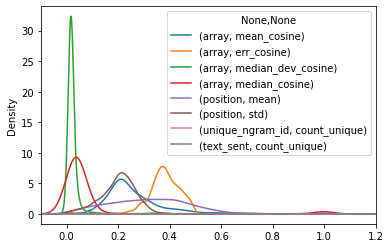

In [42]:
result.drop(
    [("cluster", "count"), ("text_id", "count_unique"), ("start", "mean"), ("start", "std")]
    , axis=1).plot(kind="kde", xlim=(-0.1, 1.2));

In [34]:
result = result.reset_index()

In [35]:
result

short_ngram_id cluster       array                               \
                            mean_cosine err_cosine median_dev_cosine   
0                 0       1    0.187697   0.347577          0.017313   
1                 1       0    0.200633   0.356859          0.017194   
2                 1       1    0.198781   0.342546          0.020956   
3                 1       2    0.304753   0.434214          0.019643   
4                 1       3    0.178852   0.338333          0.019372   
...             ...     ...         ...        ...               ...   
3471           7263       0    0.091347   0.242428          0.014836   
3472           7829       0    0.232233   0.383579          0.020049   
3473           7868       0    0.125258   0.260542          0.013274   
3474           8682       1    0.152586   0.293974          0.023498   
3475           9958       0    0.117160   0.294433          0.009093   

                   cluster  position                start             \
     median_cosine   count      mean       std       mean        std   
0         0.032720    1389  0.383077  0.261306  10.938805  10.169167   
1         0.034533     198  0.371513  0.240166   9.616162   8.237228   
2         0.038525     508  0.370624  0.244294  10.811024  11.522541   
3         0.040059      18  0.359350  0.303795  13.277778  15.679907   
4         0.036941     194  0.341914  0.273491   9.092784  10.244253   
...            ...     ...       ...       ...        ...        ...   
3471      0.028560       6  0.049020  0.120073   0.833333   2.041241   
3472      0.044452       6  0.162037  0.305513   5.000000  11.278298   
3473      0.033114       6  0.172346  0.228139   6.833333   6.177918   
3474      0.057472       8  0.217201  0.246012   6.375000   8.927286   
3475      0.015957       5  0.356090  0.159325  12.200000   7.155418   

          text_id unique_ngram_id    text_sent  
     count_unique    count_unique count_unique  
0              49             495         1107  
1              38             122          145  
2              47             160          390  
3              11              11           16  
4              39              53          158  
...           ...             ...          ...  
3471            6               6            6  
3472            2               6            6  
3473            6               6            6  
3474            7               8            8  
3475            4               5            5  

[3476 rows x 14 columns]

In [36]:
result.columns = [
    "short_ngram_id", "cluster", "mean_cosine", "err_cosine", "med_dev_cos", "med_cos",
    "cnt", "pos_mean", "pos_std", "start_mean", "start_std", "uq_text", "uq_ng", "uq_ts"
]
result.head()

,short_ngram_id,cluster,mean_cosine,err_cosine,med_dev_cos,med_cos,cnt,pos_mean,pos_std,start_mean,start_std,uq_text,uq_ng,uq_ts
0,0,1,0.187697,0.347577,0.017313,0.032720,1389,0.383077,0.261306,10.938805,10.169167,49,495,1107
1,1,0,0.200633,0.356859,0.017194,0.034533,198,0.371513,0.240166,9.616162,8.237228,38,122,145
2,1,1,0.198781,0.342546,0.020956,0.038525,508,0.370624,0.244294,10.811024,11.522541,47,160,390
3,1,2,0.304753,0.434214,0.019643,0.040059,18,0.359350,0.303795,13.277778,15.679907,11,11,16
4,1,3,0.178852,0.338333,0.019372,0.036941,194,0.341914,0.273491,9.092784,10.244253,39,53,158


In [37]:
result.to_csv("metrics.csv", index=False)
result.shape

(3476, 14)

In [38]:
result.round(2).to_sql("metrics", index=False, con=db, if_exists="replace")

In [89]:
# total.groupby(
#     ["unique_ngram_id", "text_id", "sentence_id", "start", "end", "short_ngram_id", "cluster"]
# )

In [39]:
total

topic,unique_ngram_id,text_id,sentence_id,sent_length,position,start,end,short_ngram_id,cluster,array,text_sent,end_rev
5151,129,0,2,14,0.285714,4,7,8,23,"[0.041717980057001114, 0.0417637825012207, 0.0...",0:2,-7
27669,1896,0,2,14,0.285714,4,6,88,51,"[0.041717980057001114, 0.0417637825012207, 0.0...",0:2,-6
1526,32,0,4,8,0.000000,0,3,8,23,"[0.01788461208343506, 0.01789036951959133, 0.0...",0:4,-3
25475,1589,0,9,15,0.000000,0,3,65,1,"[0.015648286789655685, 0.015653664246201515, 0...",0:9,-3
91312,58122,0,9,15,0.400000,6,9,266,1,"[0.015648286789655685, 0.015653664246201515, 0...",0:9,-9
...,...,...,...,...,...,...,...,...,...,...,...,...
128386,171324,48,2154,78,0.038462,3,7,1674,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9618847966194153, ...",48:2154,-7
128388,171330,48,2154,78,0.038462,3,6,180,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9618847966194153, ...",48:2154,-6
91317,58128,48,2154,78,0.051282,4,8,1674,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9618847966194153, ...",48:2154,-8
128387,171329,48,2154,78,0.051282,4,7,180,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.9618847966194153, ...",48:2154,-7


In [ ]:
что даст удаление этого элемента отдельно или по очереди

In [40]:
un_clusters = total.groupby(by=["short_ngram_id", "cluster"], as_index=None).agg({"text_sent": count_unique})
un_clusters = un_clusters[un_clusters["text_sent"] > 2]

In [41]:
from tqdm import tqdm

In [42]:
un_clusters = un_clusters.sort_values(by="text_sent", ascending=False)

un_clusters.head()

,short_ngram_id,cluster,text_sent
1014,20,0,6110
34,4,0,2882
3782,103,0,2066
7078,297,0,2007
748,14,1,1672


<AxesSubplot:ylabel='Frequency'>

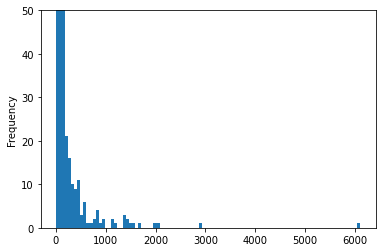

In [43]:
un_clusters["text_sent"].plot(kind="hist", bins=100, ylim=(0, 50))

In [53]:
# def mean_cosine(x):
#     return np.nanmean(get_cosine(x))

# def err_cosine(x):
#     if len(x) == 1:
#         return None
#     return np.nanstd(get_cosine(x))

# def count_unique(x):
#     return len(x.unique())

# def median_dev_cosine(x):
#     return median_abs_deviation(get_cosine(x), axis=None, nan_policy="omit")

# def median_cosine(x):
#     return np.nanmedian(get_cosine(x))

In [44]:
def compute_one_group(subset):
    A = subset["array"]
    cosine_matrix = get_cosine(A)
    cosines = np.nanmean(cosine_matrix, axis=0)
    subset["mean_cos"] = cosines
    subset["initial_positions"] = np.argsort(cosines)

    n = len(A)
    means = [None] * n
    positions = [None] * n

    for j in range(len(cosines)):
        x = np.argsort(np.nanmean(cosine_matrix, axis=0))[0]
        cosine_matrix[j, :] = np.nan
        cosine_matrix[:, j] = np.nan
        if np.nansum(cosine_matrix) > 0:
            means[x] = np.nanmean(cosine_matrix)
            positions[x] = j

    subset["means"] = means
    subset["positions"] = positions
    return subset[[
        "unique_ngram_id", "text_id", "sentence_id", "short_ngram_id", "cluster", 
        "mean_cos", "initial_positions", "means", "positions"
    ]]

In [45]:
def compute_one_group(subset):
    A = subset["array"]
    cosine_matrix = get_cosine(A)
    cosines = np.nanmean(cosine_matrix, axis=0)
    subset["mean_cos"] = cosines
    subset["initial_positions"] = np.argsort(cosines)
    
    n = len(A)
    
    S_row = np.nansum(cosine_matrix, axis=0)
    S_n_items = n
#     print("S_row initial", S_row)
#     print("S_n_items initial", S_n_items)
    
    means = [None] * n
    mean_diff = [None] * n
    positions = [None] * n
    
    curr_mean = np.nansum(S_row) / (S_n_items * (S_n_items - 1))

    for j in range(len(cosines)):
#         print(j)
#         print(S_row / S_n_items, np.argsort(S_row / S_n_items))
        x = np.argsort(S_row / S_n_items)[0]
#         print("x", x)
        
#         s_ = np.nansum(cosine_matrix[x, :]) + np.nansum(cosine_matrix[:, x])
#         print("s_", s_)
        
        
#         print("NANTONUM", np.nan_to_num(cosine_matrix[x, :], 0))
        S_row = S_row - np.nan_to_num(cosine_matrix[x, :], 0)
        S_row[x] = np.nan
#         print("S_row", S_row)
        S_n_items -= 1
#         print("S_n_items", S_n_items)
        
#         print("S_n_items", S_n_items)
        
        S_total = np.nansum(S_row)
        
        cosine_matrix[x, :] = np.nan
        cosine_matrix[:, x] = np.nan
#         S_total -= s_
#         print("S_total:", S_total)
#         print("N items:", (S_n_items * (S_n_items - 1)))
        
        if S_n_items > 0 and S_total > 10e-5:
#             print("SUM", S_total)
#             print("NEW", S_total / (S_n_items * (S_n_items - 1)))
#             print("-")
            new_mean = S_total / (S_n_items * (S_n_items - 1))
            means[x] = new_mean
            mean_diff[x] = new_mean - curr_mean 
            curr_mean = new_mean
            positions[x] = j
#         print("-" * 50)
    
    subset["means_after"] = means
    subset["mean_diff"] = mean_diff
    subset["positions"] = positions
#     print("="*100)
#     print(means)
    return subset[[
        "unique_ngram_id", "text_id", "sentence_id", "short_ngram_id", "cluster", 
        "mean_cos", "initial_positions", "means_after", "positions", "mean_diff"
    ]].sort_values(by=["short_ngram_id", "cluster", "positions"])

In [46]:
import multiprocessing

In [47]:
def run_all():    
    data_items = []
    for i in range(0, un_clusters.shape[0]):
        row = un_clusters.iloc[i]
        subset = total[(total["short_ngram_id"] == row["short_ngram_id"]) & (total["cluster"] == row["cluster"])].copy()
        data_items.append(subset)
#     print("-------", len(data_items))
    k = 100
    new_data = []
    for i in tqdm(range(int(len(data_items) / k) + 1)):
        sub_data = data_items[i * k: (i + 1) * k]
        with multiprocessing.Pool(8) as p:
            new_sub = list(p.imap(compute_one_group, sub_data))
#         new_sub = [compute_one_group(i) for i in sub_data]
        new_data.extend(new_sub)
    return new_data

In [99]:
%load_ext line_profiler

In [110]:
%lprun -f run_all run_all()

*** KeyboardInterrupt exception caught in code being profiled.

In [48]:
# del result

total = total[["array", "unique_ngram_id", "text_sent", "text_id", "sentence_id", "short_ngram_id", "cluster"]]

with open("total_pre_run.pkl", "wb") as f:
    pickle.dump(total, f)

In [112]:
import pickle

with open("total_pre_run.pkl", "rb") as f:
    total = pickle.load(f)
    

    
un_clusters = total.groupby(by=["short_ngram_id", "cluster"], as_index=None).agg({"text_sent": count_unique})
un_clusters = un_clusters[un_clusters["text_sent"] > 2]

In [49]:
new_data = run_all()

100%|██████████| 68/68 [00:39<00:00,  1.74it/s]


In [ ]:
cosines[0] = np.nan
cosines[1] = np.nan

In [50]:
# pd.concat(run_all())

In [51]:
df = pd.concat(new_data)

df.to_csv("mean_cos.csv", index=False)

In [52]:
df.round(5).to_sql("__cluster_core", con=db, index=False, if_exists="replace")

``` sql
CREATE TABLE cluster_core_metric AS
SELECT short_ngram_id, cluster, count(text_id) as total_n, 
	round((sum(means_after >= 0.9 or means_after IS NULL or mean_cos >= 0.9)) * 1.0 /  count(text_id), 2) as core9,
	round((sum(means_after >= 0.8 or means_after IS NULL or mean_cos >= 0.8)) * 1.0 /  count(text_id), 2) as core8
FROM __cluster_core
GROUP BY short_ngram_id, cluster
HAVING core9 >= 0.75
ORDER BY core9, core8 DESC
```

In [81]:
df = pd.read_sql_query("""
SELECT 
	ngram_coords.unique_ngram_id, ngram_coords.text_id, text_name, text_structure.ch_idx as chapter, text_structure.p_idx as paragraph, text_structure.s_idx as sentence, ngram_coords.start, ngram_coords.end, 
	ngram_coords.short_ngram_id, new_clusters.cluster, cluster_core_metric.core8, cluster_core_metric.core9, cluster_core_metric.total_n,
	group_concat(token.wordform, " ") as fulltext
FROM ngram_coords
JOIN new_clusters ON ngram_coords.unique_ngram_id = new_clusters.unique_ngram_id AND ngram_coords.short_ngram_id = new_clusters.short_ngram_id
JOIN cluster_core_metric ON new_clusters.short_ngram_id = cluster_core_metric.short_ngram_id AND new_clusters.cluster = cluster_core_metric.cluster
JOIN text_structure ON ngram_coords.text_id = text_structure.text_id AND ngram_coords.sentence_id = text_structure.sentence_id
JOIN text ON ngram_coords.text_id = text.id
JOIN text_content ON ngram_coords.text_id = text_content.text_id AND ngram_coords.sentence_id = text_content.sentence_id
JOIN token ON text_content.token_id = token.id
JOIN (
	SELECT nc.id, count(nc.id) as true_n, (end - start) + 1 as full_n
	FROM ngram_coords nc
		JOIN ngram_content con ON nc.unique_ngram_id = con.ngram_id
	GROUP BY nc.id
	HAVING true_n = full_n
) as nogaps ON nogaps.id = ngram_coords.id
WHERE text_content.idx >= ngram_coords.start AND text_content.idx <= ngram_coords.end
GROUP BY ngram_coords.text_id, text_name, text_structure.ch_idx, text_structure.p_idx, text_structure.s_idx, ngram_coords.start, ngram_coords.end, 
	ngram_coords.unique_ngram_id, ngram_coords.short_ngram_id, new_clusters.cluster, cluster_core_metric.core8, cluster_core_metric.core9
ORDER BY cluster_core_metric.core9 DESC, cluster_core_metric.core8 DESC, ngram_coords.short_ngram_id, new_clusters.cluster, 
		text_structure.text_id, text_structure.ch_idx, text_structure.p_idx, text_structure.s_idx, ngram_coords.start, ngram_coords.end DESC
""", con=db)

In [82]:
df.shape

(11334, 14)

In [83]:
df = df.drop_duplicates(
    subset=["unique_ngram_id", "short_ngram_id", "cluster", "text_id", "chapter", "paragraph", "sentence"], keep="first")
df.shape

(11194, 14)

In [84]:
df.head(10)

,unique_ngram_id,text_id,text_name,chapter,paragraph,sentence,start,end,short_ngram_id,cluster,core8,core9,total_n,fulltext
0,18212,7,Eyrbyggja saga,44,21,4,0,3,5,0,1.0,1.0,5,beiddu þeir þá snorra
1,18212,14,Grettis saga Ásmundarsonar,67,3,1,11,14,5,0,1.0,1.0,5,beiddi hann þá guðmund
2,18212,47,Sturlunga,296,5,4,1,4,5,0,1.0,1.0,5,hann beiddi sturlu þá
3,25717,47,Sturlunga,296,5,4,1,3,5,0,1.0,1.0,5,hann beiddi sturlu
4,183160,47,Sturlunga,469,2,4,0,3,5,0,1.0,1.0,5,beiddi hann þorgils þar
5,22200,46,Heimskringla,371,11,1,9,12,6,7,1.0,1.0,3,sem hann kvað á
6,235160,47,Sturlunga,108,18,1,9,11,6,7,1.0,1.0,3,þeir kváðust þegar
7,22200,47,Sturlunga,227,6,10,15,18,6,7,1.0,1.0,3,sem hann kvað á
8,111916,34,Reykdæla saga,24,8,4,23,26,6,33,1.0,1.0,4,nú sendi hann þegar
9,376457,37,Vatnsdæla saga,25,5,2,8,11,6,33,1.0,1.0,4,þar sem þér senduð


In [74]:
# df.groupby(["short_ngram_id", "cluster"])["total_n"].transform(len)

In [85]:
df["total_n"] = df.groupby(["short_ngram_id", "cluster"])["total_n"].transform(len)

In [86]:
df[df["total_n"] >= 3]

,unique_ngram_id,text_id,text_name,chapter,paragraph,sentence,start,end,short_ngram_id,cluster,core8,core9,total_n,fulltext
0,18212,7,Eyrbyggja saga,44,21,4,0,3,5,0,1.00,1.00,5,beiddu þeir þá snorra
1,18212,14,Grettis saga Ásmundarsonar,67,3,1,11,14,5,0,1.00,1.00,5,beiddi hann þá guðmund
2,18212,47,Sturlunga,296,5,4,1,4,5,0,1.00,1.00,5,hann beiddi sturlu þá
3,25717,47,Sturlunga,296,5,4,1,3,5,0,1.00,1.00,5,hann beiddi sturlu
4,183160,47,Sturlunga,469,2,4,0,3,5,0,1.00,1.00,5,beiddi hann þorgils þar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11329,455448,19,Gunnlaugs saga ormstungu,6,42,1,7,12,8484,0,0.75,0.75,4,eg gunnlaugi að mér þykir hann
11330,558782,4,Droplaugarsona saga,6,7,1,5,11,9817,1,0.75,0.75,4,það vildi eg björn að þú létir
11331,514060,9,Fljótsdæla saga,13,58,1,4,10,9817,1,0.75,0.75,4,það vildi eg að þið fengjuð nollar
11332,403386,32,Ljósvetninga saga - C-gerð,11,2,1,6,12,9817,1,0.75,0.75,4,það vildi eg guðmundur að þú tækir


In [87]:
df.to_sql("topic_ngram_final", con=db, if_exists="replace")

In [125]:
df = pd.read_sql_query("""
SELECT 
	ngram_coords.unique_ngram_id, ngram_coords.text_id, text_name, text_structure.ch_idx as chapter, text_structure.p_idx as paragraph, text_structure.s_idx as sentence, ngram_coords.start, ngram_coords.end, 
	ngram_coords.short_ngram_id, new_clusters.cluster, sl.sent_length,
	group_concat(token.wordform, " ") as fulltext
FROM ngram_coords
JOIN new_clusters ON ngram_coords.unique_ngram_id = new_clusters.unique_ngram_id AND ngram_coords.short_ngram_id = new_clusters.short_ngram_id
JOIN text_structure ON ngram_coords.text_id = text_structure.text_id AND ngram_coords.sentence_id = text_structure.sentence_id
JOIN text ON ngram_coords.text_id = text.id
JOIN text_content ON ngram_coords.text_id = text_content.text_id AND ngram_coords.sentence_id = text_content.sentence_id
JOIN token ON text_content.token_id = token.id
JOIN (
	SELECT nc.id, count(nc.id) as true_n, (end - start) + 1 as full_n
	FROM ngram_coords nc
		JOIN ngram_content con ON nc.unique_ngram_id = con.ngram_id
	GROUP BY nc.id
	HAVING true_n = full_n
) as nogaps ON nogaps.id = ngram_coords.id
JOIN (
	SELECT text_id, sentence_id, max(idx) + 1 as sent_length
		FROM text_content
	GROUP BY text_id, sentence_id
) as sl ON ngram_coords.text_id = sl.text_id AND ngram_coords.sentence_id = sl.sentence_id
WHERE text_content.idx >= ngram_coords.start AND text_content.idx <= ngram_coords.end
GROUP BY ngram_coords.text_id, text_name, text_structure.ch_idx, text_structure.p_idx, text_structure.s_idx, ngram_coords.start, ngram_coords.end, 
	ngram_coords.unique_ngram_id, ngram_coords.short_ngram_id, new_clusters.cluster
ORDER BY ngram_coords.short_ngram_id, new_clusters.cluster, 
		text_structure.text_id, text_structure.ch_idx, text_structure.p_idx, text_structure.s_idx, ngram_coords.start, ngram_coords.end DESC
""", con=db)

In [126]:
df.shape

(215870, 12)

In [127]:
df = df.drop_duplicates(
    subset=["unique_ngram_id", "short_ngram_id", "cluster", "text_id", "chapter", "paragraph", "sentence"], keep="first")
df.shape

(211853, 12)

In [128]:
df["position"] = df["start"] / df["sent_length"]

In [129]:
df["position_mean"] = df.groupby(["short_ngram_id", "cluster"])["position"].transform(np.mean)
df["position_err"] = df.groupby(["short_ngram_id", "cluster"])["position"].transform(np.std)
df["start_mean"] = df.groupby(["short_ngram_id", "cluster"])["start"].transform(np.mean)
df["start_err"] = df.groupby(["short_ngram_id", "cluster"])["start"].transform(np.std)
df["total_n"] = df.groupby(["short_ngram_id", "cluster"])["position"].transform(len)

In [130]:
df = df[df["total_n"] >= 3]
df.shape

(196869, 18)

In [133]:
df_start = df[df["start_err"] < 0.5][
    ["unique_ngram_id", "text_id", "text_name", "chapter", "paragraph", "sentence", 
     "start", "end", "short_ngram_id", "cluster", "sent_length", "fulltext", "total_n"
    ]]
df_start.shape

(1698, 13)

In [134]:
df_start = df_start.drop_duplicates(
    subset=["short_ngram_id", "cluster", "text_id", "chapter", "paragraph", "sentence"], keep="first")
df_start["total_n"] = df_start.groupby(["short_ngram_id", "cluster"])["chapter"].transform(len)
df_start = df_start[df_start["total_n"] >= 3]
df_start.shape

(1088, 13)

In [135]:
df_start.to_sql("ngram_start_final", con=db, if_exists="replace")

In [120]:
df[df["start_err"] < 0.05][["start_err", "short_ngram_id", "cluster", "total_n"]].drop_duplicates()

,start_err,short_ngram_id,cluster,total_n
8812,0.027848,4,3,3.0
8989,0.000000,4,9,4.0
9003,0.030259,4,11,6.0
9009,0.038490,4,12,3.0
9166,0.032449,4,24,3.0
...,...,...,...,...
215699,0.018496,10319,0,3.0
215730,0.026243,10634,0,3.0
215818,0.041907,11679,0,3.0
215823,0.016981,11713,0,3.0


In [152]:
df = pd.read_sql_query("""
SELECT 
	ngram_coords.unique_ngram_id, ngram_coords.sentence_id, ngram_coords.text_id, text_name, text_structure.ch_idx as chapter, text_structure.p_idx as paragraph, text_structure.s_idx as sentence, ngram_coords.start, ngram_coords.end, 
	ngram_coords.short_ngram_id, new_clusters.cluster, sl.sent_length,
	group_concat(token.wordform, " ") as fulltext
FROM ngram_coords
JOIN new_clusters ON ngram_coords.unique_ngram_id = new_clusters.unique_ngram_id AND ngram_coords.short_ngram_id = new_clusters.short_ngram_id
JOIN cluster_core_metric ON new_clusters.short_ngram_id = cluster_core_metric.short_ngram_id AND new_clusters.cluster = cluster_core_metric.cluster
JOIN text_structure ON ngram_coords.text_id = text_structure.text_id AND ngram_coords.sentence_id = text_structure.sentence_id
JOIN text ON ngram_coords.text_id = text.id
JOIN text_content ON ngram_coords.text_id = text_content.text_id AND ngram_coords.sentence_id = text_content.sentence_id
JOIN token ON text_content.token_id = token.id
JOIN (
	SELECT nc.id, count(nc.id) as true_n, (end - start) + 1 as full_n
	FROM ngram_coords nc
		JOIN ngram_content con ON nc.unique_ngram_id = con.ngram_id
	GROUP BY nc.id
	HAVING true_n = full_n
) as nogaps ON nogaps.id = ngram_coords.id
JOIN (
	SELECT text_id, sentence_id, max(idx) + 1 as sent_length
		FROM text_content
	GROUP BY text_id, sentence_id
) as sl ON ngram_coords.text_id = sl.text_id AND ngram_coords.sentence_id = sl.sentence_id
WHERE text_content.idx >= ngram_coords.start AND text_content.idx <= ngram_coords.end AND cluster_core_metric.core8 >= 0.5
GROUP BY ngram_coords.text_id, text_name, text_structure.ch_idx, text_structure.p_idx, text_structure.s_idx, ngram_coords.start, ngram_coords.end, 
	ngram_coords.unique_ngram_id, ngram_coords.short_ngram_id, new_clusters.cluster
ORDER BY ngram_coords.short_ngram_id, new_clusters.cluster, 
		text_structure.text_id, text_structure.ch_idx, text_structure.p_idx, text_structure.s_idx, ngram_coords.start, ngram_coords.end DESC
""", con=db)

In [153]:
df["text_sent"] = df["text_id"].apply(str) + ":" + df["sentence_id"].apply(str)

In [154]:
df = df.drop_duplicates(
    subset=["short_ngram_id", "cluster", "text_sent"], keep="first")
df.shape

(8941, 14)

In [155]:
df["unique_text"] = df.groupby(["short_ngram_id", "cluster"])["text_id"].transform(lambda x: len(set(x)))
df["unique_sentences"] = df.groupby(["short_ngram_id", "cluster"])["text_sent"].transform(lambda x: len(set(x)))

In [156]:
df["unique_text"].unique()

array([4, 2, 3, 6, 5, 1, 7, 8])

In [158]:
df.to_sql("ngram_by_text_final", con=db, if_exists="replace")